In [5]:
import pandas as pd
import random
import os
import itertools
from tqdm import tqdm
import numpy as np
import pickle
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [6]:
def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [7]:
# read datasets
corum_human = pd.read_table('general_datasets/corum_humanComplexes.txt')
corum_human.index = corum_human['complex_id']

ge_matrix = pickle.load(open('general_datasets/ge_matrix.pkl', 'rb'))

##### 1. Global correlation signals between gene essentiality profiles of intra- and inter-complex gene pairs derived from CORUM database

In [8]:
# constructing sets of intra- and inter-complex gene pairs

subunit_id = {}
for i in corum_human.index:
    subunits = tuple(sorted(list(set(corum_human['subunits_gene_name'][i].split(';')))))
    subunit_id[i] = subunits

posippis_all = set()
for i in subunit_id.keys():
    subunits = subunit_id[i]
    if len(subunits) >= 2:
        combinations = list(itertools.combinations(subunits, 2))
        for combination in combinations:
            t = sorted(list(combination))
            posippis_all.add((t[0], t[1]))

seeds = [42]

# intra-complex gene pairs
posippi_seed = {}
posippi_id_seed = {}
posisubunit_id_seed = {}
for i in tqdm(subunit_id.keys()):
    subunits = subunit_id[i]
    if len(subunits) >= 2:
        combinations = sorted(list(itertools.combinations(subunits, 2)))
        if len(subunits) <= 5:
            for s in seeds:
                ppis = set()
                posisubunits = set()
                for combination in combinations:
                    t = sorted(list(combination))
                    ppis.add((t[0], t[1]))
                    posisubunits = posisubunits.union(set(combination))
                    try:
                        posippi_seed[s].add((t[0], t[1]))
                    except:
                        posippi_seed[s] = set()
                        posippi_seed[s].add((t[0], t[1]))
                try:
                    posippi_id_seed[s][i] = ppis
                except:
                    posippi_id_seed[s] = {}
                    posippi_id_seed[s][i] = ppis

                try:
                    posisubunit_id_seed[s][i] = posisubunits
                except:
                    posisubunit_id_seed[s] = {}
                    posisubunit_id_seed[s][i] = posisubunits

        else:
            for s in seeds:
                setup_seed(s)
                combinations_ = random.sample(combinations, len(subunits) * 2)
                ppis = set()
                posisubunits = set()
                for combination in combinations_:
                    t = sorted(list(combination))
                    ppis.add((t[0], t[1]))
                    posisubunits = posisubunits.union(set(combination))
                    try:
                        posippi_seed[s].add((t[0], t[1]))
                    except:
                        posippi_seed[s] = set()
                        posippi_seed[s].add((t[0], t[1]))
                try:
                    posippi_id_seed[s][i] = ppis
                except:
                    posippi_id_seed[s] = {}
                    posippi_id_seed[s][i] = ppis

                try:
                    posisubunit_id_seed[s][i] = posisubunits
                except:
                    posisubunit_id_seed[s] = {}
                    posisubunit_id_seed[s][i] = posisubunits

# inter-complex gene pairs
negappi_seed = {}
for s in seeds:
    posisubunit_id = posisubunit_id_seed[s]
    ids = sorted(list(posisubunit_id.keys()))

    negapair = sorted(list(itertools.combinations(ids, 2)))

    setup_seed(s)
    negapair = random.sample(negapair, 200000)
    negapair = sorted(list(negapair))

    negappi = set()
    for i in tqdm(negapair):
        cs = sorted(list(i))
        c1, c2 = cs[0], cs[1]
        subunits_1 = sorted(list(posisubunit_id[c1]))
        subunits_2 = sorted(list(posisubunit_id[c2]))

        setup_seed(s)
        s_1 = random.choice(subunits_1)
        s_2 = random.choice(subunits_2)

        ppi = set([s_1, s_2])
        if len(ppi) == 2:
            ppi_ = sorted(list(ppi))
            negappi.add((ppi_[0], ppi_[1]))

    negappi = negappi-posippis_all
    negappi = sorted(list(negappi))

    setup_seed(s)
    random.shuffle(negappi)
    
    negappi_seed[s] = negappi


100%|██████████| 200000/200000 [00:06<00:00, 32084.10it/s]


In [9]:
# calculating Pearson coefficients respectively

genes_all_key = {}
genes_all_key['CRISPR'] = list(ge_matrix['CRISPR'].columns)
genes_all_key['RNAi'] = list(ge_matrix['RNAi'].columns)

# intra-
posipc_s_key = {}
for ge_key in ['CRISPR', 'RNAi']:
    posipc_s = {}
    for s in seeds:
        posipc_lst = []
        
        posippi = posippi_seed[s]
        
        for ppi in tqdm(posippi):
            ppi_lst = sorted(list(ppi))
            g1 = ppi_lst[0]
            g2 = ppi_lst[1]

            genes_all = genes_all_key[ge_key]
            if g1 in genes_all and g2 in genes_all:
                ge_1 = ge_matrix[ge_key][g1].dropna()
                ge_2 = ge_matrix[ge_key][g2].dropna()

                ccls_inter = list(set(ge_1.index) & set(ge_2.index))
                ge_final_1 = ge_1[ccls_inter]
                ge_final_2 = ge_2[ccls_inter]

                if len(ccls_inter) >= 10:
                    # pearson相关性系数
                    pearson_r = pearsonr(ge_final_1, ge_final_2)

                    pearson_coeff = pearson_r[0]

                    posipc_lst.append(pearson_coeff)
        posipc_s[s] = posipc_lst
    posipc_s_key[ge_key] = posipc_s

# inter-
negapc_s_key = {}
for ge_key in ['CRISPR', 'RNAi']:
    negapc_s = {}
    for s in seeds:
        negapc_lst = []

        negappi = negappi_seed[s]

        posipc = posipc_s_key[ge_key][s]

        for ppi in tqdm(negappi):
            ppi_lst = sorted(list(ppi))
            g1 = ppi_lst[0]
            g2 = ppi_lst[1]

            genes_all = genes_all_key[ge_key]
            if g1 in genes_all and g2 in genes_all:
                ge_1 = ge_matrix[ge_key][g1].dropna()
                ge_2 = ge_matrix[ge_key][g2].dropna()

                ccls_inter = list(set(ge_1.index) & set(ge_2.index))
                ge_final_1 = ge_1[ccls_inter]
                ge_final_2 = ge_2[ccls_inter]

                if len(ccls_inter) >= 10:
                    # pearson相关性系数
                    pearson_r = pearsonr(ge_final_1, ge_final_2)

                    pearson_coeff = pearson_r[0]

                    negapc_lst.append(pearson_coeff)

                    if len(negapc_lst) == len(posipc):
                        break

        negapc_s[s] = negapc_lst
    negapc_s_key[ge_key] = negapc_s


 10%|▉         | 16022/166938 [00:46<07:19, 343.40it/s]


CRISPR, p-value:  0.0
RNAi, p-value:  3.4837345606654083e-217


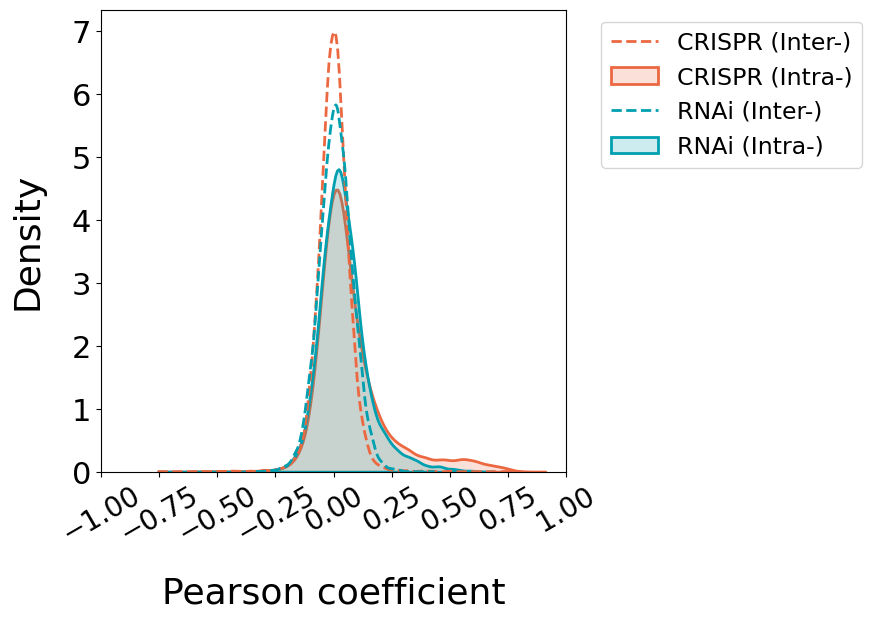

In [59]:
# drawing density plot

plt.figure(figsize=(6, 6))
ge_key = 'CRISPR'

negapc = negapc_s_key[ge_key][s]
sns.kdeplot(negapc, cut=0, fill=False, color='#eb6841',ls='--',
            alpha=1, linewidth=2,label='CRISPR (Inter-)')

posipc = posipc_s_key[ge_key][s]
sns.kdeplot(posipc, cut=0, fill=True, color='#eb6841',
            alpha=0.2, linewidth=2,label='CRISPR (Intra-)')

p_value = stats.ttest_ind(negapc, posipc)[1]
print('CRISPR, p-value: ',p_value)

ge_key = 'RNAi'

negapc = negapc_s_key[ge_key][s]
sns.kdeplot(negapc, cut=0, fill=False, color='#00a0b0',ls='--',
            alpha=1, linewidth=2,label='RNAi (Inter-)')

posipc = posipc_s_key[ge_key][s]
sns.kdeplot(posipc, cut=0, fill=True, color='#00a0b0',
            alpha=0.2, linewidth=2,label='RNAi (Intra-)')

p_value = stats.ttest_ind(negapc, posipc)[1]
print('RNAi, p-value: ',p_value)

plt.yticks(ha='right', fontsize=22)
plt.xticks(ha='center', fontsize=20,rotation=30)
plt.ylabel('Density', fontsize=26, labelpad=20)
plt.xlabel('Pearson coefficient', fontsize=26, labelpad=20)
plt.xlim(-1,1)
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0), fontsize=17, markerfirst=True,
           markerscale=1, scatterpoints=1, ncol=1, title_fontsize=17)
plt.rcParams['figure.dpi'] = 100
plt.show()

##### 2. Filtering of non-random negative gene essentiality values

100%|██████████| 16810/16810 [00:29<00:00, 575.39it/s]


CRISPR -0.236628213691729
RNAi -0.3247122025148999


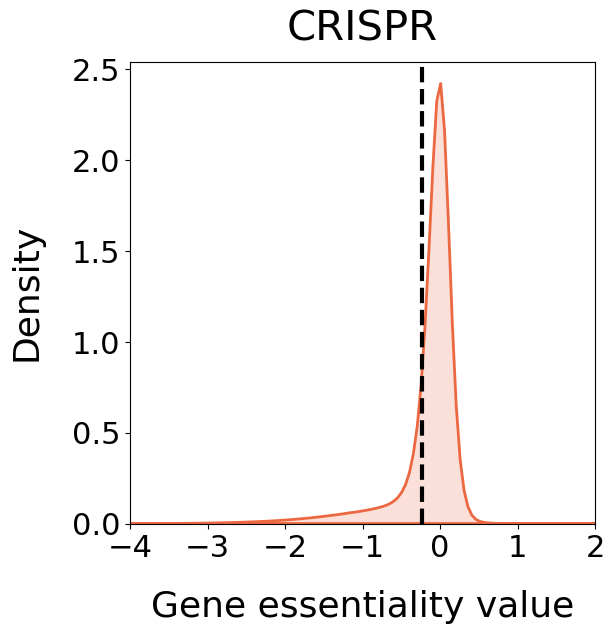

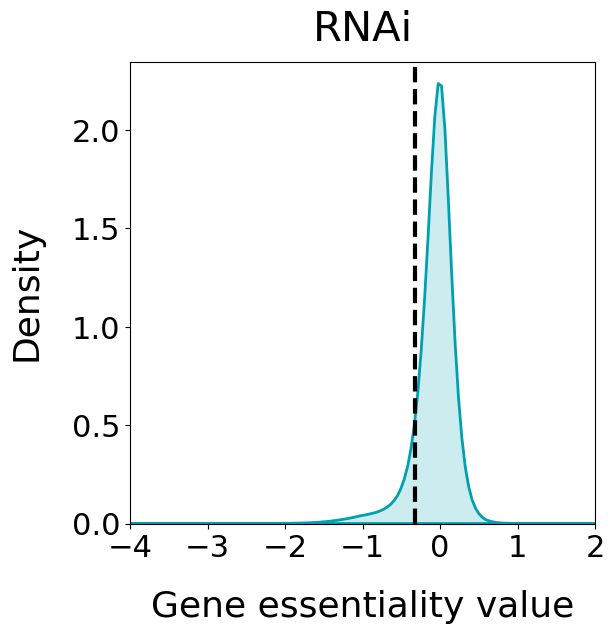

In [3]:
ge_all = {}
for ge_key in ['CRISPR', 'RNAi']:
    records = []
    genes_key = list(ge_matrix[ge_key].columns)
    for gene in tqdm(genes_key):
        s = ge_matrix[ge_key][gene].dropna()
        for i in s.index:
            records.append((ge_key, gene, i, s[i]))
    ge_df = pd.DataFrame(records, columns=['ge_key', 'gene', 'cell_line', 'value'])
    ge_all[ge_key] = ge_df

ge_cut = {}
for ge_key in ['CRISPR', 'RNAi']:
    ge_s = ge_all[ge_key]['value']
    ge_s_right = ge_s[ge_s > ge_s.mean()]
    ge_s_right_95 = np.percentile(ge_s_right, 95)
    ge_s_cut = -1 * ge_s_right_95
    print(ge_key, ge_s_cut)

# ge_cut
ge_cut = {}
ge_cut['CRISPR'] = -0.237
ge_cut['RNAi'] = -0.325

for ge_key in ['CRISPR', 'RNAi']:
    values = ge_matrix[ge_key].values.flatten()
    values = values[~np.isnan(values)]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    color = '#eb6841' if ge_key == 'CRISPR' else '#00a0b0'
    sns.kdeplot(values, cut=0, fill=True, color=color, alpha=0.2, linewidth=2)
    plt.axvline(x=ge_cut[ge_key], ls='--', color='black', lw=3)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlim(-4, 2)
    plt.ylabel('Density', fontsize=26, labelpad=20)
    plt.xlabel('Gene essentiality value', fontsize=26, labelpad=20)
    plt.title(ge_key, fontsize=30, pad=15)
    plt.rcParams['figure.dpi'] = 100
    plt.show()

##### 3. Refined correlation signals after filtering uninformative contexts

In [10]:
# calculating Pearson coefficients respectively

# ge_cut
ge_cut = {}
ge_cut['CRISPR'] = -0.237
ge_cut['RNAi'] = -0.325

# intra-
fposipc_s_key = {}
for ge_key in ['CRISPR', 'RNAi']:
    fposipc_s = {}
    for s in seeds:
        fposipc_lst = []

        posippi = posippi_seed[s]

        for ppi in tqdm(posippi):
            ppi_lst = sorted(list(ppi))
            g1 = ppi_lst[0]
            g2 = ppi_lst[1]

            genes_all = genes_all_key[ge_key]
            if g1 in genes_all and g2 in genes_all:
                ge_1 = ge_matrix[ge_key][g1].dropna()
                ge_2 = ge_matrix[ge_key][g2].dropna()

                ge_f_1 = ge_1[ge_1 < ge_cut[ge_key]]
                ge_f_2 = ge_2[ge_2 < ge_cut[ge_key]]

                ccls_inter = list(set(ge_f_1.index) & set(ge_f_2.index))
                ge_final_1 = ge_f_1[ccls_inter]
                ge_final_2 = ge_f_2[ccls_inter]

                if len(ccls_inter) >= 10:
                    # pearson相关性系数
                    pearson_r = pearsonr(ge_final_1, ge_final_2)

                    pearson_coeff = pearson_r[0]

                    fposipc_lst.append(pearson_coeff)
        fposipc_s[s] = fposipc_lst
    fposipc_s_key[ge_key] = fposipc_s

# inter-
fnegapc_s_key = {}
for ge_key in ['CRISPR', 'RNAi']:
    fnegapc_s = {}
    for s in seeds:
        fnegapc_lst = []

        negappi = negappi_seed[s]

        posipc = fposipc_s_key[ge_key][s]

        for ppi in tqdm(negappi):
            ppi_lst = sorted(list(ppi))
            g1 = ppi_lst[0]
            g2 = ppi_lst[1]

            genes_all = genes_all_key[ge_key]
            if g1 in genes_all and g2 in genes_all:
                ge_1 = ge_matrix[ge_key][g1].dropna()
                ge_2 = ge_matrix[ge_key][g2].dropna()

                ge_f_1 = ge_1[ge_1 < ge_cut[ge_key]]
                ge_f_2 = ge_2[ge_2 < ge_cut[ge_key]]

                ccls_inter = list(set(ge_f_1.index) & set(ge_f_2.index))
                ge_final_1 = ge_f_1[ccls_inter]
                ge_final_2 = ge_f_2[ccls_inter]

                if len(ccls_inter) >= 10:
                    # pearson相关性系数
                    pearson_r = pearsonr(ge_final_1, ge_final_2)

                    pearson_coeff = pearson_r[0]
                    pearson_p = pearson_r[1]

                    fnegapc_lst.append(pearson_coeff)

                    if len(fnegapc_lst) == len(posipc):
                        break

        fnegapc_s[s] = fnegapc_lst
    fnegapc_s_key[ge_key] = fnegapc_s


 16%|█▌        | 26699/166938 [00:41<03:36, 647.78it/s]


CRISPR, p-value:  3.695401435386024e-09
RNAi, p-value:  1.0685122851512014e-94


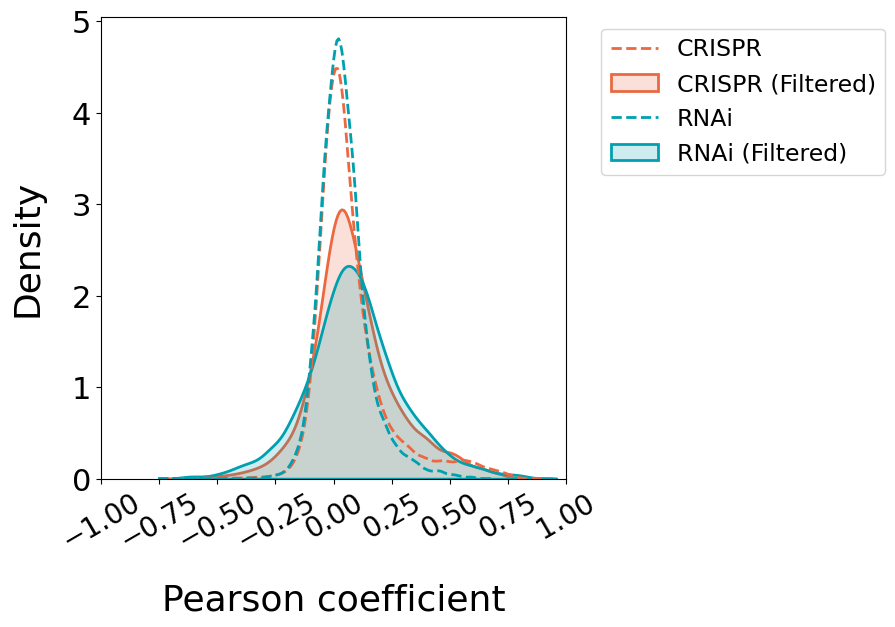

In [13]:
# drawing density plot

plt.figure(figsize=(6, 6))
ge_key = 'CRISPR'

posipc = posipc_s_key[ge_key][s]
sns.kdeplot(posipc, cut=0, fill=False, color='#eb6841',ls='--',
            alpha=1, linewidth=2,label='CRISPR')

fposipc = fposipc_s_key[ge_key][s]
sns.kdeplot(fposipc, cut=0, fill=True, color='#eb6841',
            alpha=0.2, linewidth=2,label='CRISPR (Filtered)')

p_value = stats.ttest_ind(posipc, fposipc)[1]
print('CRISPR, p-value: ',p_value)

ge_key = 'RNAi'

posipc = posipc_s_key[ge_key][s]
sns.kdeplot(posipc, cut=0, fill=False, color='#00a0b0',ls='--',
            alpha=1, linewidth=2,label='RNAi')

fposipc = fposipc_s_key[ge_key][s]
sns.kdeplot(fposipc, cut=0, fill=True, color='#00a0b0',
            alpha=0.2, linewidth=2,label='RNAi (Filtered)')

p_value = stats.ttest_ind(posipc, fposipc)[1]
print('RNAi, p-value: ',p_value)

plt.yticks(ha='right', fontsize=22)
plt.xticks(ha='center', fontsize=20,rotation=30)
plt.ylabel('Density', fontsize=26, labelpad=20)
plt.xlabel('Pearson coefficient', fontsize=26, labelpad=20)
plt.xlim(-1,1)
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0), fontsize=17, markerfirst=True,
           markerscale=1, scatterpoints=1, ncol=1, title_fontsize=17)
plt.rcParams['figure.dpi'] = 100
plt.show()